### Import All Neccesary Libraries

In [1]:
# ! pip install usaddress
# ! pip install spacy

import spacy
import re
import pandas as pd
from spacy import displacy
from spacy.attrs import LOWER 
from collections import Counter
from spacy.matcher import Matcher
import numpy as np
import usaddress
import requests
import pandas as pd

import nltk
from nltk.tokenize import RegexpTokenizer

# !python -m spacy download en_core_web_sm
import en_core_web_sm
nlp = en_core_web_sm.load()

In [2]:
# Set column width to be larger to display more content
pd.options.display.max_colwidth = 1000

### Import the Transcribed Audio

In [3]:
df1 = pd.read_csv("./Datasets/transcribed_audio/Feed25818_May2020_01AM_to_03PM_transcript_Alex.csv")
df1 = df1[['file_name','confidence','transcript']]
df1.head(2)

,file_name,confidence,transcript
0,sample786-25818-20200501-0442.wav,0.637047,Thursday
1,sample116-25818-20200501-0941.wav,0.764874,returning from the second alarm to go off in fact about


In [4]:
df2 = pd.read_csv("./Datasets/transcribed_audio/Feed25818_May2020_10AM_to_12AM_transcript_Zach.csv")
df2 = df2.drop(columns = ['audio_length', 'transcribe_time'])
df2.head(2)

,file_name,confidence,transcript
0,sample-1-25818-20200502-1017-8558.wav,0.797743,I think that says okay moral
1,sample-1-25818-20200502-1017-8558.wav,0.812221,what


In [5]:
df3 = pd.read_excel("./Datasets/transcribed_audio/watertown_manhunt_transcript.xlsx")
df3 = df3.drop(columns = ['Unnamed: 1'])
df3['confidence'] = None
df3['file_name'] = 'watertown_manhunt'
df3 = df3[['file_name','confidence','transcript']]

In [6]:
df4 = pd.read_csv("./Datasets/transcribed_audio/enhanced-test-df.csv")
df4 = df4[['file_name','confidence','transcript']]
df4.head(2)

,file_name,confidence,transcript
0,sample282-enhanced-25818-20200502-1401.wav,0.780835,no he is currently outside
1,sample76-enhanced-25818-20200502-1332.wav,0.535276,I think one of the empty.


In [7]:
df = pd.concat([df1,df3,df2]).reset_index().drop(columns=['index'])
df

,file_name,confidence,transcript
0,sample786-25818-20200501-0442.wav,0.637047,Thursday
1,sample116-25818-20200501-0941.wav,0.764874,returning from the second alarm to go off in fact about
2,sample92-25818-20200501-0941.wav,0.692422,having a t show jokes to 19219 South Street
3,sample635-25818-20200501-1439.wav,0.643082,but I'm trying to we went through a window we found a party took social housing waiting for the window
4,sample697-25818-20200501-0243.wav,0.609950,407
...,...,...,...
3041,sample-9-25818-20200502-2229-19283.wav,0.721903,chat again you have like a beeping noise in the background
3042,sample-9-25818-20200502-2229-19283.wav,0.758561,yep the only one in the same time together
3043,sample-9-25818-20200502-2258-24835.wav,0.785126,we're an apartment 3016 culture the cover off okay the company be responsible 376 are companies responding to box 3726 close to your age 22
3044,sample-9-25818-20200502-2328-3018.wav,0.670549,that's when Kodak instamatic


### Import List of Streets

In [8]:
street_list = pd.read_csv('./Datasets/Metro_West_Streets.csv')
streets_list = street_list['0'].tolist()
streets_list[:10]

['3rd',
 'Aberdeen',
 'Academy',
 'Acton',
 'Adamian',
 'Adams',
 'Addison',
 'Aerial',
 'Albermarle',
 'Alfred']

### Tokenize the Transcribed Audio

In [9]:
# adapted from Michael Allen (pythonhealthcare.org)

def identify_tokens(row):
    tran = row['transcript']
    tokens = nltk.word_tokenize(tran)
    # taken only words (not punctuation)
    token_words = [w for w in tokens if w.isalpha()]
    return token_words

df['tokens'] = df.apply(identify_tokens,
                        axis=1)

### Identify and Match Street Names from the Audio Transcripts

Code Adapted from: Grant Wilson San Francisco Cohort

In [10]:
# Instantiate the Spacy Matcher Function
matcher = Matcher(nlp.vocab)

# Create a matching function
def on_match(matcher, doc, id, matches):
    return matches

# building patterns for every road name
def build_pattern(road_name):
    list_words = road_name.split(' ')
    # ensure capitlization does not affect the model 
    pattern = [{'LOWER': word.lower()} for word in list_words]
    return pattern

# Get a pattern of every road
for road in streets_list:
    matcher.add(road, on_match, build_pattern(road))
    
# capitalize all the strings
def capitalize_string(string_in):
    words = string_in.split(' ')
    string_out = ''
    for i in words:
        string_out += i.capitalize() + ' '
    string_out = string_out[:-1]
    return string_out   
    
# Look for locations in the transcript, then extract them
def location_extraction_context(string_in):
    doc = nlp(string_in)
    string_out = ''
    list_words = string_in.split(' ')
    matches = matcher(doc)
    if len(matches) == 0:
        return None

    # loop through the matches and make sure they all follow the same format
    for match in matches:
        list_pattern = matcher.get(match[0])[1][0]
        for token in list_pattern:
            string_out += token['LOWER'] + ' '
        string_out += ', '
    string_out = string_out[:-3]
    string_out = capitalize_string(string_out)
    return string_out

# Add a column consisting of the extracted streets
df['streets'] = df['transcript'].map(location_extraction_context)

### Find Possible Street Numbers

In [11]:
# Creat list to house data from all addresses
addresses = []

# Loop Through all DataFrame's rows
for row in df['transcript']:
    # Create dictionary to house data for each row of the DataFrame
    d = {}
    
    # Parse through rows and house results in a list
    list_tuples = usaddress.parse(row)
    
    # Create variable to house list of possible numbers
    numbers = []
    
    # Loop through each value in the list created
    for i, n in enumerate(list_tuples):
        
        # Get addresses' numbers
        if list_tuples[i][1] == 'AddressNumber':
            
            # Append numbers to list
            numbers.append(n[0])
    
    # Include keys and values into d
    d['numbers'] = numbers
    
    # Append d to addresses
    addresses.append(d)

Above Code Adapted from: Grant Wilson San Francisco Cohort

### Add Street Number Column to the Dataframe

In [12]:
df = pd.concat([df, 
                pd.DataFrame(addresses)], axis=1)

In [13]:
# Drop NaNs
df.dropna(inplace=True)
df.reset_index(drop=True,
               inplace=True)

In [14]:
df.shape

(1513, 6)

### Generate a List of All Possible Adresses for each Row in the Transcript

Above Code Adapted from: Grant Wilson San Francisco Cohort

In [15]:
# Creat list to house data for possible addresses
possibilities = []

# Loop Through all DataFrame's rows
for i in range(0, df.shape[0]):
    
    # Create variables to temporarily house information
    final_poss = []
    d = {}
    number_poss = []
    
    # Loop through values in each row / numbers
    for row in df[i:i+1]['numbers']:
        for a_number in row:
            number_poss.append(a_number)
    
    # Loop through values in each row / streets
    street_poss = []
    for row2 in [x.split(',') for x in df[i:(i+1)]['streets']][0]:
        for j in row2.split(','):
            street_poss.append(j.strip())

    # Concatenate numbers and streets
    for i in number_poss:
        for j in street_poss:
            final_poss.append(i + ' ' + j)

    # Append all possibilities to list
    d['full_streets'] = list(set(final_poss))
    possibilities.append(d)

# Concatenate dataframes
df = pd.concat([df, pd.DataFrame(possibilities)], axis=1)

In [16]:
df

,file_name,confidence,transcript,tokens,streets,numbers,full_streets
0,sample116-25818-20200501-0941.wav,0.764874,returning from the second alarm to go off in fact about,"[returning, from, the, second, alarm, to, go, off, in, fact, about]","The , Off",[],[]
1,sample92-25818-20200501-0941.wav,0.692422,having a t show jokes to 19219 South Street,"[having, a, t, show, jokes, to, South, Street]",South,[19219],[19219 South]
2,sample635-25818-20200501-1439.wav,0.643082,but I'm trying to we went through a window we found a party took social housing waiting for the window,"[but, I, trying, to, we, went, through, a, window, we, found, a, party, took, social, housing, waiting, for, the, window]",The,[],[]
3,sample396-25818-20200501-1140.wav,0.787601,CMS said that they were told by somebody up here that they were up and they walked off and went downstairs that needs to be fine at least jumped on,"[CMS, said, that, they, were, told, by, somebody, up, here, that, they, were, up, and, they, walked, off, and, went, downstairs, that, needs, to, be, fine, at, least, jumped, on]",Off,[],[]
4,sample217-25818-20200501-0612.wav,0.722337,for calling Broadway,"[for, calling, Broadway]",Broadway,[],[]
...,...,...,...,...,...,...,...
1508,sample-9-25818-20200502-2159-19588.wav,0.832902,off of 104 1st Ave on the Callback,"[off, of, Ave, on, the, Callback]","Off , 1st , The",[104],"[104 1st, 104 Off, 104 The]"
1509,sample-9-25818-20200502-2229-19283.wav,0.721903,chat again you have like a beeping noise in the background,"[chat, again, you, have, like, a, beeping, noise, in, the, background]",The,[],[]
1510,sample-9-25818-20200502-2229-19283.wav,0.758561,yep the only one in the same time together,"[yep, the, only, one, in, the, same, time, together]","The , The",[],[]
1511,sample-9-25818-20200502-2258-24835.wav,0.785126,we're an apartment 3016 culture the cover off okay the company be responsible 376 are companies responding to box 3726 close to your age 22,"[we, an, apartment, culture, the, cover, off, okay, the, company, be, responsible, are, companies, responding, to, box, close, to, your, age]","The , Off , The",[],[]


### Drop Blanks

In [17]:
df['full_streets'] = df['full_streets'].map(lambda x: np.nan if len(x) == 0 else x)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [18]:
df.shape

(418, 7)

In [19]:
df

,file_name,confidence,transcript,tokens,streets,numbers,full_streets
0,sample92-25818-20200501-0941.wav,0.692422,having a t show jokes to 19219 South Street,"[having, a, t, show, jokes, to, South, Street]",South,[19219],[19219 South]
1,sample52-25818-20200501-1240.wav,0.659737,495 North despite a 13 sat on the 1st and 2nd traveling,"[North, despite, a, sat, on, the, and, traveling]","North , The , 1st , 2nd",[495],"[495 North, 495 2nd, 495 1st, 495 The]"
2,sample1232-25818-20200501-1310.wav,0.726749,"Island, 47th Street. Our address is 7173 Highland, 373 Highland Avenue","[Island, Street, Our, address, is, Highland, Highland, Avenue]","Highland , Highland , Avenue",[373],"[373 Highland, 373 Avenue]"
3,sample882-25818-20200501-0044.wav,0.711468,please request at 2525 Rockdale Circle,"[please, request, at, Rockdale, Circle]",Circle,[2525],[2525 Circle]
4,sample644-25818-20200501-1439.wav,0.820020,that's cool is that $12 Street Hyde Park letter 28 for medical assistance $12 Street Hyde Park new Xbox 3831 River and Ellis Street 1417,"[that, cool, is, that, Street, Hyde, Park, letter, for, medical, assistance, Street, Hyde, Park, new, Xbox, River, and, Ellis, Street]","Hyde , Park , Hyde , Park , New , River , Ellis",[3831],"[3831 New, 3831 Ellis, 3831 Hyde, 3831 Park, 3831 River]"
...,...,...,...,...,...,...,...
413,sample-8-25818-20200502-2159-7857.wav,0.756348,coming in a person with a knife 291 Huntington Ave thank you stop saw someone can feel like you can talk to them and stuff and pulled out a knife,"[coming, in, a, person, with, a, knife, Huntington, Ave, thank, you, stop, saw, someone, can, feel, like, you, can, talk, to, them, and, stuff, and, pulled, out, a, knife]","Huntington , Saw",[291],"[291 Huntington, 291 Saw]"
414,sample-8-25818-20200502-2258-8783.wav,0.758969,before that was all things I wanted to 70 years old,"[before, that, was, all, things, I, wanted, to, years, old]",Old,[70],[70 Old]
415,sample-9-25818-20200502-1152-9845.wav,0.712878,"32032 Hyde Park respiratory to 11. Street number 11 9th Street Maria, 137","[Hyde, Park, respiratory, to, Street, number, Street, Maria]","Hyde , Park , 9th","[32032, 11]","[11 9th, 32032 Hyde, 11 Hyde, 32032 9th, 11 Park, 32032 Park]"
416,sample-9-25818-20200502-1601-16399.wav,0.716539,when 3950 Northern Avenue,"[when, Northern, Avenue]","Northern , Avenue",[3950],"[3950 Avenue, 3950 Northern]"


### Export

In [22]:
df.to_csv("./Datasets/transcript_with_addresses_ENHANCED_AUDIO.csv")

# Visualize

In [20]:
import seaborn as sns

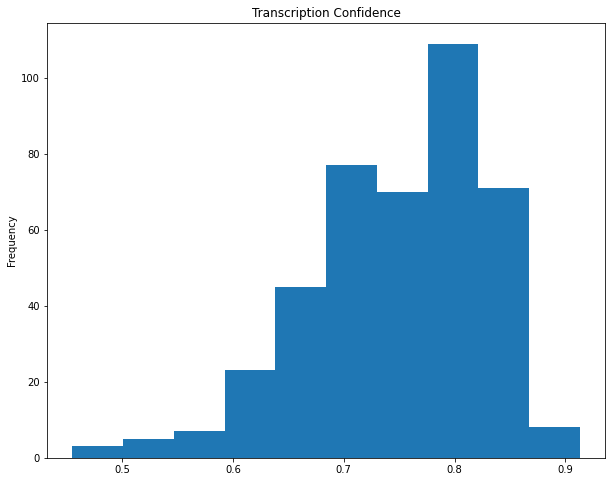

In [33]:
df['confidence'].plot(kind = 'hist',x = 'Confidence', title = 'Transcription Confidence', figsize = (10,8))

Text(0.5, 0, 'Confidence')

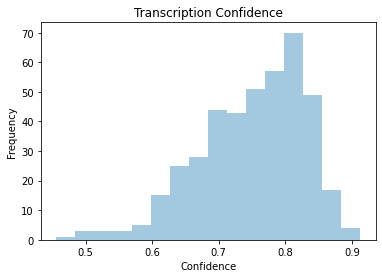

In [43]:
ax = sns.distplot(df['confidence'], kde = False)
ax.set_title('Transcription Confidence')
ax.set_ylabel("Frequency")
ax.set_xlabel("Confidence")

In [31]:
df['confidence'].mean()

0.7504046533724146